In [1]:
import findspark
findspark.init()

import pyspark
sc = pyspark.SparkContext(appName="Textanalysis")

### Parse and load data

In [2]:
import re
import string
# The file format of an Amazon line is: "id","title","description","manufacturer","price"

#The file format of a Google line is: "id","name","description","manufacturer","price"

datafile_patern = "^(.+),(.+),(.*),(.*),(.*)"
stopwords = set(sc.textFile('googleamazondata/stopwords.txt').collect())
quickbrownfox = 'A quick brown fox jumps over the lazy dog.'

def removeQuotes(s):
    """ Remove quotation marks from an input string
    Args:
        s (str): input string that might have the quote "" characters
    Returns:
        str: a string without the quote characters
    """
    return ''.join(i for i in s if i!='"')


In [3]:
def parsedatafileline(datafileline):
    '''
    Args:
        datafileline (str): input string that is a line from data file
    Returns:
        str : a string parsed using regular expression and without punctuation
    '''
    
    match = re.search(datafile_patern, datafileline)
    
    if match is None:
        print('invalid datafileline: %s' %datafileline)
        return(datafileline, -1)
    elif match.group(1) == 'id':
        print('Header datafile line: %s' % datafileline)
        return(datafileline, 1)
    else:
        product = "%s %s %s" %(match.group(2), match.group(3),match.group(4))
        return ((removeQuotes(match.group(1)), product),1)
    

In [4]:
import os

baseDir = os.path.join('googleamazondata')

GOOGLE_PATH = 'google.csv'
GOOGLE_SMALL_PATH = 'googlesmall.csv'
AMAZON_PATH = 'amazon.csv'
AMAZON_SMALL_PATH = 'amazonsmall.csv'
GOLD_STANDARD_PATH = 'mapping.csv'
STOPWORDS_PATH = 'stopwords.txt'

In [5]:
def parsedata(filename):
    
    return (sc
            .textFile(filename, 4, 0)
            .map(lambda x: x.decode('utf-8'))
            .map(parsedatafileline)
            .cache())

def loadData(path):
    filename = os.path.join(baseDir, path)
    raw = parsedata(filename)
    failed = (raw
              .filter(lambda x: x[1] == -1)
              .map(lambda x: x[0]))
    for line in failed.take(10):
        print('%s - invalid datafile line: %s'%(path, line))
    valid = (raw
             .filter(lambda x: x[1] == 1)
             .map(lambda x: x[0])
             .cache())
    print ('%s - Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (path,
                                                                                        raw.count(),
                                                                                        valid.count(),
                                                                                        failed.count()))
    assert failed.count() == 0
    assert raw.count() == valid.count()
    
    return valid
        
    

In [6]:
googleSmall = loadData(GOOGLE_SMALL_PATH)
google = loadData(GOOGLE_PATH)
amazonSmall = loadData(AMAZON_SMALL_PATH)
amazon = loadData(AMAZON_PATH)

googlesmall.csv - Read 201 lines, successfully parsed 201 lines, failed to parse 0 lines
google.csv - Read 3227 lines, successfully parsed 3227 lines, failed to parse 0 lines
amazonsmall.csv - Read 201 lines, successfully parsed 201 lines, failed to parse 0 lines
amazon.csv - Read 1364 lines, successfully parsed 1364 lines, failed to parse 0 lines


In [7]:
# examine 3 lines from each small dataset
for line in googleSmall.take(3):
    print ('google: %s: %s\n' % (line[0], line[1]))

for line in amazonSmall.take(3):
    print ('amazon: %s: %s\n' % (line[0], line[1]))

google: id: "name" "description" "manufacturer"

google: http://www.google.com/base/feeds/snippets/11448761432933644608: "spanish vocabulary builder" "expand your vocabulary! contains fun lessons that both teach and entertain you'll quickly find yourself mastering new terms. includes games and more!" 

google: http://www.google.com/base/feeds/snippets/8175198959985911471: "topics presents: museums of world" "5 cd-rom set. step behind the velvet rope to examine some of the most treasured collections of antiquities art and inventions. includes the following the louvre - virtual visit 25 rooms in full screen interactive video detailed map of the louvre ..." 

amazon: id: "title" "description" "manufacturer"

amazon: b000jz4hqo: "clickart 950 000 - premier image pack (dvd-rom)"  "broderbund"

amazon: b0006zf55o: "ca international - arcserve lap/desktop oem 30pk" "oem arcserve backup v11.1 win 30u for laptops and desktops" "computer associates"



### 1) ER as Text Similarity - Bags of Words

#### clean and tokenize a string

In [8]:
def removepunctuationtokenize(text, stopwords=None, split=False):
    '''
    Args : 
        text(str): input string that might contains punctuations
    Returns:
        str : a string clean of punctuation
    '''
    
    regex = re.compile('[%s]'%string.punctuation)
    text = regex.sub('', text.lower()).strip()
    text = ''.join([x for x in text if ord(x)<208])
    if split:
        return [x for x in text.split() if x not in stopwords]
    else:
        return text

#### Tokenizing the small datasets

In [9]:
amazontoken = amazonSmall.map(lambda line: (line[0], removepunctuationtokenize(line[1],stopwords,split=True)))
googletoken = googleSmall.map(lambda line: (line[0], removepunctuationtokenize(line[1], stopwords, split=True)))

In [10]:
def countTokens(vendorrdd):
    return vendorrdd.map(lambda x: len(x[1])).reduce(lambda a,b: a+b)

In [11]:
totalTokens = countTokens(amazontoken) + countTokens(googletoken)
print('There are %s tokens in the combined datasets' % totalTokens)

There are 21525 tokens in the combined datasets


#### top 5 Amazon records with the most tokens

In [12]:
print('Top 5 amazon records with most tokens are:\n')
for tup in amazontoken.map(lambda x: (x[0],len(x[1]))).takeOrdered(5, lambda x: -x[1]):
    print('Amazon ID %s: %s tokens'%(tup[0],tup[1]))

Top 5 amazon records with most tokens are:

Amazon ID b000o24l3q: 1487 tokens
Amazon ID b000ndibtg: 1424 tokens
Amazon ID b000i2qubi: 726 tokens
Amazon ID b000ndicuy: 433 tokens
Amazon ID b000h22pg8: 422 tokens


#### top 5 Google records with the most tokens

In [13]:
print('Top 5 amazon records with most tokens are:\n')
for tup in googletoken.map(lambda x: (x[0],len(x[1]))).takeOrdered(5, lambda x: -x[1]):
    print('Amazon ID %s: %s tokens'%(tup[0],tup[1]))

Top 5 amazon records with most tokens are:

Amazon ID http://www.google.com/base/feeds/snippets/18431066094306345892: 57 tokens
Amazon ID http://www.google.com/base/feeds/snippets/18354453970523580051: 44 tokens
Amazon ID http://www.google.com/base/feeds/snippets/17651109278239417595: 44 tokens
Amazon ID http://www.google.com/base/feeds/snippets/18363672170449359273: 43 tokens
Amazon ID http://www.google.com/base/feeds/snippets/18403148885652932189: 43 tokens


### 2) ER as Text Similarity - Weighted Bag-of-Words using TF-IDF

In [14]:
def tf(tokens):
    """ Compute TF
    Args:
        tokens (list of str): input list of tokens from tokenize
    Returns:
        dictionary: a dictionary of tokens to its TF values
    """
    total = len(tokens)
    counts = {}
    for token in tokens:
        if token in counts:
            counts[token] = counts[token] + 1
        else:
            counts[token] = 1
    return {k: float(v) / total for k, v in counts.items()}

print(tf(removepunctuationtokenize(quickbrownfox, stopwords, split=True)))

{'jumps': 0.16666666666666666, 'lazy': 0.16666666666666666, 'fox': 0.16666666666666666, 'brown': 0.16666666666666666, 'dog': 0.16666666666666666, 'quick': 0.16666666666666666}


In [15]:
# Create a corpus
corpusRdd = amazontoken.union(googletoken)

In [16]:
#Implement an IDFs function
def idfs(corpus):
    N = corpus.count()
    uniquetokens = corpus.map(lambda x: set(x[1]))
    tokencountpairtuple = uniquetokens.flatMap(lambda x: [(i,1) for i in x])
    tokensumpairtuple   = tokencountpairtuple.reduceByKey(lambda a,b: a+b)
    return(tokensumpairtuple.map(lambda x: (x[0], float(N)/x[1])))

In [17]:
idfsSmall = idfs(corpusRdd)
uniqueTokenCount = idfsSmall.count()

In [18]:
print('There are %s unique tokens in the small datasets.' % uniqueTokenCount)

There are 5095 unique tokens in the small datasets.


In [19]:
#Tokens with the smallest IDF
smallIDFTokens = idfsSmall.takeOrdered(11, lambda s: s[1])
print (smallIDFTokens)

[('software', 4.276595744680851), ('features', 6.931034482758621), ('new', 7.052631578947368), ('complete', 7.3090909090909095), ('create', 8.375), ('windows', 8.73913043478261), ('system', 8.73913043478261), ('powerful', 9.571428571428571), ('use', 9.804878048780488), ('win', 9.804878048780488), ('tools', 10.05)]


(array([  20.,   63.,   78.,   64.,   62.,   92.,   71.,  107.,    0.,
         139.,    0.,    0.,  247.,    0.,    0.,    0.,  398.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,  962.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 2792.]),
 array([  4.27659574,  12.23106383,  20.18553191,  28.14      ,
         36.09446809,  44.04893617,  52.00340426,  59.95787234,
         67.91234043,  75.86680851,  83.8212766 ,  91.77574468,
         99.73021277, 107.68468085, 115.63914894, 123.59361702,
        131.54808511, 139.50255319, 147.45702128, 155.41148936,
        163.36595745, 171.32042553, 179.27489362, 187.2293617 ,
        195.18382979, 203.13829787, 211.09276596, 219.04723404,
        227.00170213, 234.95617021, 242.9106383 , 250.86510638,
        258.81957447, 266.77404255, 274.72851064, 282.68297872,
        290.63744681, 29

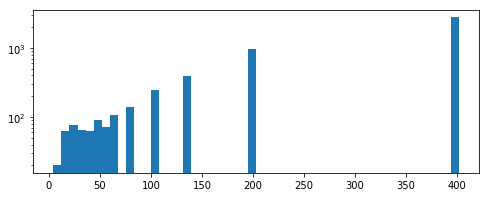

In [20]:
#IDF Histogram
import matplotlib.pyplot as plt
%matplotlib inline 

small_idf_values = idfsSmall.map(lambda s: s[1]).collect()
fig = plt.figure(figsize=(8,3))
plt.hist(small_idf_values, 50, log=True)

In [21]:
# Implement a TF-IDF function
def tfidf(tokens, idfs):
    tfs = tf(tokens)
    tfIdfDict = {k:v*idfs[k] for k,v in tfs.items()}
    return tfIdfDict


    

In [22]:
recb000hkgj8k = amazontoken.filter(lambda x: x[0] == 'b000hkgj8k').collect()[0][1]
idfsSmallWeights = idfsSmall.collectAsMap()
rec_b000hkgj8k_weights = tfidf(recb000hkgj8k, idfsSmallWeights)

print('Amazon record "b000hkgj8k" has tokens and weights:\n%s' % rec_b000hkgj8k_weights)

Amazon record "b000hkgj8k" has tokens and weights:
{'psg': 33.5, '2007': 3.722222222222222, 'customizing': 16.75, 'courseware': 67.0, 'autocad': 33.5, 'interface': 3.0454545454545454, 'autodesk': 8.375}


### 3) ER as Text Similarity - Cosine Similarity

In [23]:
import math

def dotprod(a, b):
    """ Compute dot product
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
    Returns:
        dotProd: result of the dot product with the two input dictionaries
    """
    totalsum = 0.
    for k1, v1 in a.items():
        for k2, v2 in b.items():
            if k1 == k2:
                totalsum += v1 * v2
    return totalsum

def norm(a):
    """ Compute square root of the dot product
    Args:
        a (dictionary): a dictionary of record to value
    Returns:
        norm: a dictionary of tokens to its TF values
    """
    return math.sqrt(dotprod(a, a))

def cossim(a, b):
    """ Compute cosine similarity
    Args:
        a (dictionary): first dictionary of record to value
        b (dictionary): second dictionary of record to value
    Returns:
        cossim: dot product of two dictionaries divided by the norm of the first dictionary and
                then by the norm of the second dictionary
    """
    return dotprod(a, b) / (norm(a) * norm(b))

testVec1 = {'foo': 2, 'bar': 3, 'baz': 5 }
testVec2 = {'foo': 1, 'bar': 0, 'baz': 20 }
dp = dotprod(testVec1, testVec2)
nm = norm(testVec1)
print (dp, nm,cossim(testVec1,testVec2))

102.0 6.164414002968976 0.8262970212292282


#### Implement a cosineSimilarity function

In [24]:
def cosineSimilarity(string1, string2, idfsDictionary):
    """ Compute cosine similarity between two strings
    Args:
        string1 (str): first string
        string2 (str): second string
        idfsDictionary (dictionary): a dictionary of IDF values
    Returns:
        cossim: cosine similarity value
    """
    w1 = tfidf(removepunctuationtokenize(string1, stopwords, split=True), idfsDictionary)
    w2 = tfidf(removepunctuationtokenize(string2, stopwords, split=True), idfsDictionary)
    return cossim(w1, w2)

cossimAdobe = cosineSimilarity('Adobe Photoshop',
                               'Adobe Illustrator',
                               idfsSmallWeights)
cossimAdobe

0.05772433821630338

#### Perform Entity Resolution

In [25]:
crossSmall = (googleSmall
              .cartesian(amazonSmall)
              .cache())

In [26]:
def computeSimilarity(record):
    """ Compute similarity on a combination record
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallWeights)
    return (googleURL, amazonID, cs)

similarities = (crossSmall
                .map(lambda x: computeSimilarity(x))
                .cache())

def similar(amazonID, googleURL):
    """ Return similarity value
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similarities
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

In [27]:
similarityAmazonGoogle = similar('b000o24l3q','http://www.google.com/base/feeds/snippets/17242822440574356561')
print ('Requested similarity is %s.' % similarityAmazonGoogle)

Requested similarity is 0.0003207472319016042.


#### Perform Entity Resolution with Broadcast Variables

In [28]:
def computeSimilarityBroadcast(record):
    """ Compute similarity on a combination record, using Broadcast variable
    Args:
        record: a pair, (google record, amazon record)
    Returns:
        pair: a pair, (google URL, amazon ID, cosine similarity value)
    """
    googleRec = record[0]
    amazonRec = record[1]
    googleURL = googleRec[0]
    amazonID = amazonRec[0]
    googleValue = googleRec[1]
    amazonValue = amazonRec[1]
    cs = cosineSimilarity(googleValue, amazonValue, idfsSmallBroadcast.value)
    return (googleURL, amazonID, cs)

idfsSmallBroadcast = sc.broadcast(idfsSmallWeights)
similaritiesBroadcast = (crossSmall
                         .map(lambda x: computeSimilarityBroadcast(x))
                         .cache())

def similarBroadcast(amazonID, googleURL):
    """ Return similarity value, computed using Broadcast variable
    Args:
        amazonID: amazon ID
        googleURL: google URL
    Returns:
        similar: cosine similarity value
    """
    return (similaritiesBroadcast
            .filter(lambda record: (record[0] == googleURL and record[1] == amazonID))
            .collect()[0][2])

similarityAmazonGoogleBroadcast = similarBroadcast('b000o24l3q', 'http://www.google.com/base/feeds/snippets/17242822440574356561')
print ('Requested similarity is %s.' % similarityAmazonGoogleBroadcast)

Requested similarity is 0.0003207472319016042.


#### Perform a Gold Standard evaluation

In [29]:
GOLDFILE_PATTERN = '^(.+),(.+)'

def parse_goldfile_line(goldfile_line):
    
    
    match = re.search(GOLDFILE_PATTERN, goldfile_line)
    
    if match is None:
        print('Invalide Golfile line: %s'%goldfile_line)
        return(goldfile_line, -1)
    elif match.group(1) == '"idAmazon"':
        print('The header is: %s'%goldfile_line)
        return(goldfile_line, 0)
    else:
        key = '%s %s' % (removeQuotes(match.group(1)), removeQuotes(match.group(2)))
        return ((key, 'gold'), 1)
    
    
goldfile = os.path.join(baseDir, GOLD_STANDARD_PATH)
gsRaw = (sc
         .textFile(goldfile)
         .map(parse_goldfile_line)
         .cache())

gsfailed = (gsRaw
            .filter(lambda x: x[1] == -1)
            .map(lambda x: x[0]))

for line in gsfailed.take(10):
    print('Invalid goldfile line: %s' % line)
    

goldStandard = (gsRaw
                .filter(lambda s: s[1] == 1)
                .map(lambda s: s[0])
                .cache())

print ('Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (gsRaw.count(),
                                                                                 goldStandard.count(),
                                                                                 gsfailed.count()))

Read 1301 lines, successfully parsed 1300 lines, failed to parse 0 lines


In [30]:
#Q: How many true duplicate pairs are there in the small datasets?
#Q: What is the average similarity score for true duplicates?
#Q: What about for non-duplicates? 

sims = similaritiesBroadcast.map(lambda x: (x[1] + ' ' + x[0], x[2]))

trueDupsRDD = sims.join(goldStandard)
trueDupsCount = trueDupsRDD.count()
avgSimDups = trueDupsRDD.map(lambda x: x[1][0]).reduce(lambda a, b: a + b) / trueDupsCount

trueDupsOrigRDD = trueDupsRDD.map(lambda x: (x[0],x[1][0]))
nonDupsRDD = sims.subtract(trueDupsOrigRDD)
avgSimNon = nonDupsRDD.map(lambda x: x[1]).reduce(lambda a, b: a + b) / nonDupsRDD.count()

print ('There are %s true duplicates.' % trueDupsCount)
print ('The average similarity of true duplicates is %s.' % avgSimDups)
print ('And for non duplicates, it is %s.' % avgSimNon)

There are 146 true duplicates.
The average similarity of true duplicates is 0.2555319924185273.
And for non duplicates, it is 0.001055458878033001.


### Scalable ER

#### Tokenize the full dataset

In [31]:
amazonFullRecToToken = amazon.map(lambda line: (line[0], removepunctuationtokenize(line[1], stopwords, split=True)))
googleFullRecToToken = google.map(lambda line: (line[0], removepunctuationtokenize(line[1], stopwords, split=True)))
print ('Amazon full dataset is %s products, Google full dataset is %s products' % (amazonFullRecToToken.count(),
                                                                                    googleFullRecToToken.count()))

Amazon full dataset is 1364 products, Google full dataset is 3227 products


#### Compute IDFs and TF-IDFs for the full datasets

In [32]:
fullCorpusRDD = amazonFullRecToToken.union(googleFullRecToToken)
idfsFull = idfs(fullCorpusRDD)
idfsFullCount = idfsFull.count()

print ('There are %s unique tokens in the full datasets.' % idfsFullCount)

There are 19646 unique tokens in the full datasets.


In [33]:
# Recompute IDFs for full dataset
idfsFullWeights = idfsFull.collectAsMap()
idfsFullBroadcast = sc.broadcast(idfsFullWeights)

# Pre-compute TF-IDF weights.  Build mappings from record ID weight vector.
amazonWeightsRDD = amazonFullRecToToken.map(lambda x: (x[0], tfidf(x[1], idfsFullBroadcast.value)))
googleWeightsRDD = googleFullRecToToken.map(lambda x: (x[0], tfidf(x[1], idfsFullBroadcast.value)))
print('There are %s Amazon weights and %s Google weights.' % (amazonWeightsRDD.count(),
                                                              googleWeightsRDD.count()))

There are 1364 Amazon weights and 3227 Google weights.


#### Compute Norms for the weights from the full datasets

In [34]:
amazonNorms = amazonWeightsRDD.map(lambda x: (x[0], norm(x[1])))
amazonNormsBroadcast = sc.broadcast(amazonNorms.collect())
googleNorms = googleWeightsRDD.map(lambda x: (x[0], norm(x[1])))
googleNormsBroadcast = sc.broadcast(googleNorms.collect())

In [35]:
# TODO: Replace <FILL IN> with appropriate code
def invert(record):
    """ Invert (ID, tokens) to a list of (token, ID)
    Args:
        record: a pair, (ID, token vector)
    Returns:
        pairs: a list of pairs of token to ID
    """
    id = record[0]
    weights = record[1]
    pairs = [(token, id) for (token, weight) in weights.items()]
    return (pairs)

amazonInvPairsRDD = (amazonWeightsRDD
                    .flatMap(lambda x: invert(x))
                    .cache())

googleInvPairsRDD = (googleWeightsRDD
                    .flatMap(lambda x: invert(x))
                    .cache())

print ('There are %s Amazon inverted pairs and %s Google inverted pairs.' % (amazonInvPairsRDD.count(),
                                                                            googleInvPairsRDD.count()))

There are 110487 Amazon inverted pairs and 74094 Google inverted pairs.


In [44]:
amazonInvPairsRDD.takeSample(False, 5)

[('easily', 'b000ogsh3c'),
 ('significantly', 'b000ndicpy'),
 ('maintain', 'b0007lw23a'),
 ('category', 'b000h22rbg'),
 ('handle', 'b000i2qubi')]

In [46]:
# TODO: Replace <FILL IN> with appropriate code
def swap(record):
    """ Swap (token, (ID, URL)) to ((ID, URL), token)
    Args:
        record: a pair, (token, (ID, URL))
    Returns:
        pair: ((ID, URL), token)
    """
    token = record[0]
    keys = record[1]
    return (keys, token)

commonTokens = (amazonInvPairsRDD
                .join(googleInvPairsRDD)
                .map(lambda x: swap(x))
                .groupByKey()
                .map(lambda x: (x[0], list(x[1])))
                .cache())

print ('Found %d common tokens' % commonTokens.count())

Found 2188443 common tokens


In [53]:
amazonWeightsBroadcast = sc.broadcast(amazonWeightsRDD.collectAsMap())
googleWeightsBroadcast = sc.broadcast(googleWeightsRDD.collectAsMap())

In [59]:
def fastCosineSimilarity(record):
    """ Compute Cosine Similarity using Broadcast variables
    Args:
        record: ((ID, URL), token)
    Returns:
        pair: ((ID, URL), cosine similarity value)
    """
    amazonRec = record[0][0]
    googleRec = record[0][1]
    tokens = record[1]
    s = sum([(amazonWeightsBroadcast.value[amazonRec][token] * googleWeightsBroadcast.value[googleRec][token]) 
             for token in tokens])
    value = s / (dict(amazonNormsBroadcast.value)[amazonRec] * dict(googleNormsBroadcast.value)[googleRec])
    key = (amazonRec, googleRec)
    return (key, value)


similaritiesFullRDD = (commonTokens
                       .map(lambda x: fastCosineSimilarity(x))
                       .cache())

print (similaritiesFullRDD.count())

2188443


In [66]:
# Create an RDD of ((Amazon ID, Google URL), similarity score)
simsFullRDD = similaritiesFullRDD.map(lambda x: ("%s %s" % (x[0][0], x[0][1]), x[1]))

# Create an RDD of just the similarity scores
simsFullValuesRDD = (simsFullRDD
                     .map(lambda x: x[1])
                     .cache())

# Look up all similarity scores for true duplicates

# This helper function will return the similarity score for records that are in the gold standard 
# and the simsFullRDD (True positives), and will return 0 for records that are in the gold standard 
# but not in simsFullRDD (False Negatives)
def gs_value(record):
    if (record[1][1] is None):
        return 0
    else:
        return record[1][1]

# Join the gold standard and simsFullRDD, and then extract the similarities scores using the helper function
trueDupSimsRDD = (goldStandard
                  .leftOuterJoin(simsFullRDD)
                  .map(gs_value)
                  .cache())
print ('There are %s true duplicates.' % trueDupSimsRDD.count())

There are 1300 true duplicates.


In [117]:
from pyspark.accumulators import AccumulatorParam
# Return a list with entry x set to value and all other entries set to 0
def set_bit(x, value, length):
    bits = []
    for y in range(length):
        if (x == y):
            bits.append(value)
        else:
            bits.append(0)
    return bits

# Pre-bin counts of false positives for different threshold ranges
BINS = 101
nthresholds = 100
def bin_(similarity):
    return int(similarity * nthresholds)

# fpCounts[i] = number of entries (possible false positives) where bin(similarity) == i
zeros = [0] * BINS
fpCounts = sc.accumulator(zeros, VectorAccumulatorParam())


In [118]:
def add_element(score):
    global fpCounts
    b = bin_(score)
    fpCounts += set_bit(b, 1, BINS)

simsFullValuesRDD.foreach(add_element)

# Remove true positives from FP counts
def sub_element(score):
    global fpCounts
    b = bin(score)
    fpCounts += set_bit(b, -1, BINS)

trueDupSimsRDD.foreach(sub_element)

In [119]:
def falsepos(threshold):
    fpList = fpCounts.value
    return sum([fpList[b] for b in range(0, BINS) if float(b) / nthresholds >= threshold])

def falseneg(threshold):
    return trueDupSimsRDD.filter(lambda x: x < threshold).count()

def truepos(threshold):
    return trueDupSimsRDD.count() - falsenegDict[threshold]

In [120]:
def precision(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falseposDict[threshold])

def recall(threshold):
    tp = trueposDict[threshold]
    return float(tp) / (tp + falsenegDict[threshold])

def fmeasure(threshold):
    r = recall(threshold)
    p = precision(threshold)
    return 2 * r * p / (r + p)

In [121]:
thresholds = [float(n) / nthresholds for n in range(0, nthresholds)]
falseposDict = dict([(t, falsepos(t)) for t in thresholds])
falsenegDict = dict([(t, falseneg(t)) for t in thresholds])
trueposDict = dict([(t, truepos(t)) for t in thresholds])

0.0005940296365955156 0.0011873539497557475


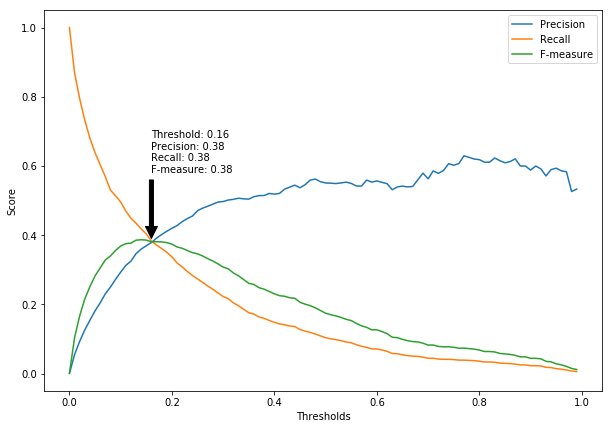

In [160]:
import matplotlib.pyplot as plt
%matplotlib inline 
precisions = [precision(t) for t in thresholds]
recalls = [recall(t) for t in thresholds]
fmeasures = [fmeasure(t) for t in thresholds]

print (precisions[0], fmeasures[0])

#helper function to find optimal threshold index
def findindex():
    for (ix,i),(jx,j),(kx,k) in zip(enumerate(precisions),enumerate(recalls),enumerate(fmeasures)):
        if round(i,2)==round(j,2)==round(k,2):
            assert ix==jx==kx
            index = ix
    return index


fig = plt.figure(figsize=(10,7))
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
plt.plot(thresholds, fmeasures)
plt.xlabel('Thresholds')
plt.ylabel('Score')

plt.annotate('Threshold: {} \nPrecision: {:.2f}\nRecall: {:.2f}\nF-measure: {:.2f}'.format(thresholds[xi],precisions[xi],recalls[xi],fmeasures[xi]),
              xy=(thresholds[xi], fmeasures[xi]), xytext=(thresholds[xi], fmeasures[xi]+0.2),
              arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend(['Precision', 'Recall', 'F-measure'])
